In [1]:
%matplotlib inline
import nibabel as nb
import numpy as np
from skimage import morphology as sim
from scipy.ndimage.morphology import binary_fill_holes
from nilearn.plotting import plot_anat
from matplotlib import pyplot as plt

In [2]:
def refine_aseg(aseg, ball_size=4):
    """
    First step to reconcile ANTs' and FreeSurfer's brain masks.

    Here, the ``aseg.mgz`` mask from FreeSurfer is refined in two
    steps, using binary morphological operations:

      1. With a binary closing operation the sulci are included
         into the mask. This results in a smoother brain mask
         that does not exclude deep, wide sulci.

      2. Fill any holes (typically, there could be a hole next to
         the pineal gland and the corpora quadrigemina if the great
         cerebral brain is segmented out).


    """
    # Read aseg data
    bmask = aseg.copy()
    bmask[bmask > 0] = 1
    bmask = bmask.astype(np.uint8)

    # Morphological operations
    selem = sim.ball(ball_size)
    newmask = sim.binary_closing(bmask, selem)
    newmask = binary_fill_holes(newmask.astype(np.uint8), selem).astype(np.uint8)

    return newmask.astype(np.uint8)


def grow_mask(anat, aseg, ants_segs=None, ww=7, zval=2.0, bw=4):
    """
    Grow mask including pixels that have a high likelihood.
    GM tissue parameters are sampled in image patches of ``ww`` size.

    This is inspired on mindboggle's solution to the problem:
    https://github.com/nipy/mindboggle/blob/master/mindboggle/guts/segment.py#L1660

    """
    selem = sim.ball(bw)

    aseg[aseg == 42] = 3  # Collapse both hemispheres
    gm = anat.copy()
    gm[aseg != 3] = 0
    
    if ants_segs is None:
        ants_segs = np.zeros_like(aseg, dtype=np.uint8)

    refined = refine_aseg(aseg)
    newrefmask = sim.binary_dilation(refined, selem) - refined
    indices = np.argwhere(newrefmask > 0)
    for pixel in indices:
        # When ATROPOS identified the pixel as GM, set and carry on
        if ants_segs[tuple(pixel)] == 2:
            refined[tuple(pixel)] = 1
            continue

        window = gm[
            pixel[0] - ww:pixel[0] + ww,
            pixel[1] - ww:pixel[1] + ww,
            pixel[2] - ww:pixel[2] + ww
        ]
        if np.any(window > 0):
            zstat = abs(anat[tuple(pixel)] - window[window > 0].mean()) / window[window > 0].std()
            refined[tuple(pixel)] = int(zstat < zval)

    refined = sim.binary_opening(refined, selem)
    return refined


/Users/oesteban/.anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in float_scalars


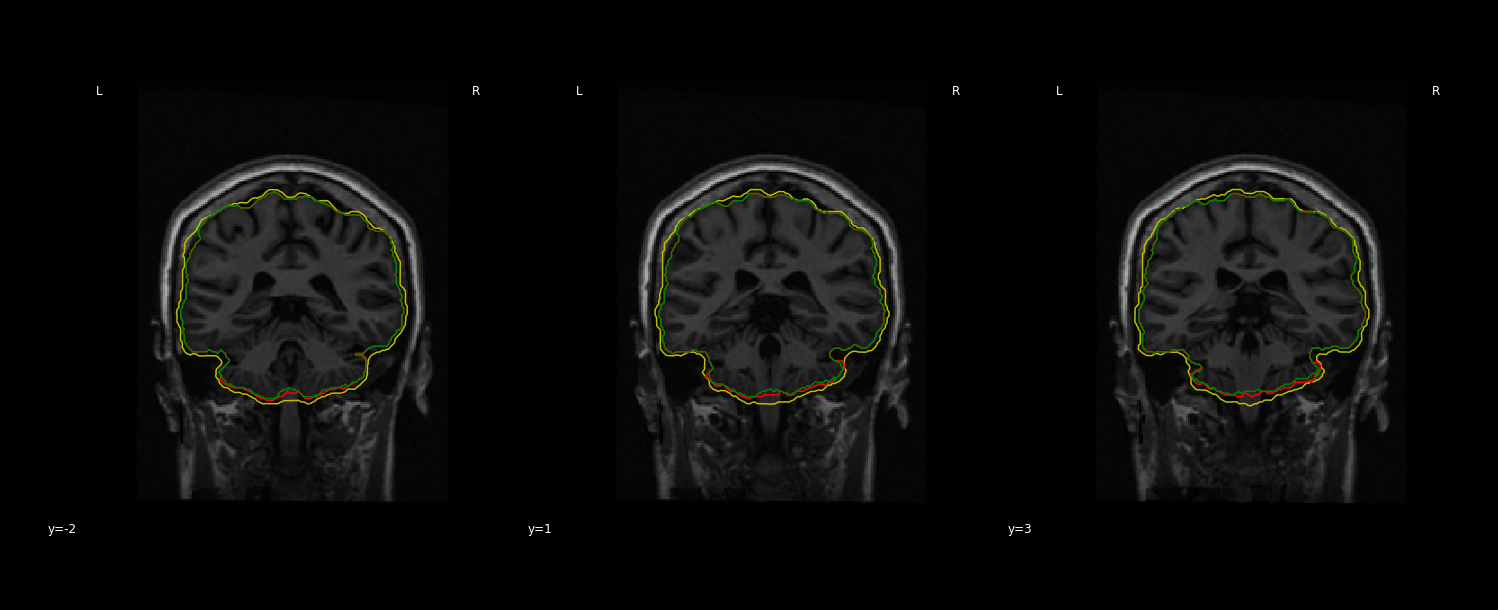

In [3]:
anatnii = nb.load('ds114/t1_correct.nii.gz')
newmask = grow_mask(
    anatnii.get_data(),
    nb.load('ds114/aseg.nii.gz').get_data(),
    nb.load('ds114/ants.nii.gz').get_data()
)
newmask[newmask > 0] = 1
newmask[newmask < 1] = 0
newmasknii = nb.Nifti1Image(newmask, anatnii.affine, anatnii.header)
newmasknii.set_data_dtype(np.uint8)
newmasknii.to_filename('ds114/mask_wgmvox.nii.gz')

newmask = grow_mask(
    anatnii.get_data(),
    nb.load('ds114/aseg.nii.gz').get_data()
)
newmask[newmask > 0] = 1
newmask[newmask < 1] = 0
newmasknii = nb.Nifti1Image(newmask, anatnii.affine, anatnii.header)
newmasknii.set_data_dtype(np.uint8)
newmasknii.to_filename('ds114/mask_wogmvox.nii.gz')

disp = plot_anat(anatnii, display_mode='y', cut_coords=[-2.0, 1.0, 3.0])
disp.add_contours('ds114/antsmask.nii.gz', levels=[0.5], colors='y')
disp.add_contours('ds114/mask_wgmvox.nii.gz', levels=[0.5], colors='r')
disp.add_contours('ds114/mask_wogmvox.nii.gz', levels=[0.5], colors='g')
plt.gcf().set_size_inches(20, 8)

/Users/oesteban/.anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in float_scalars


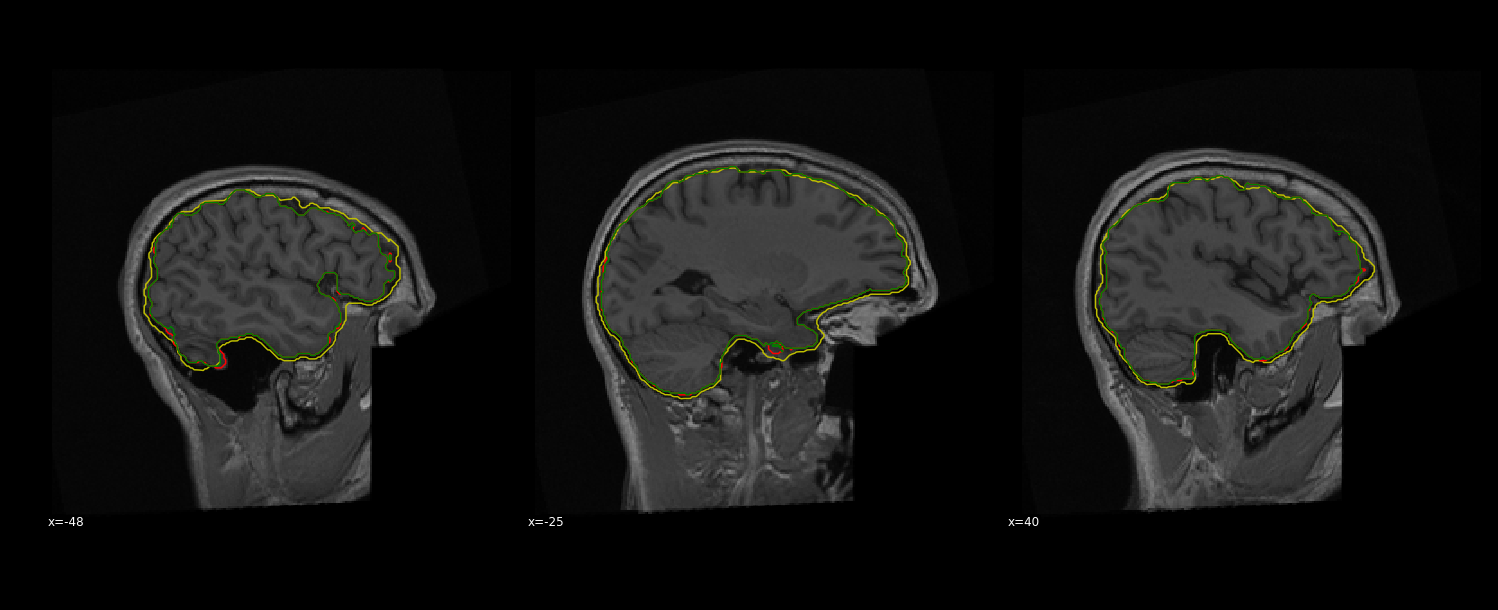

In [5]:
anatnii = nb.load('ds017/t1_correct.nii.gz')
newmask = grow_mask(
    anatnii.get_data(),
    nb.load('ds017/aseg.nii.gz').get_data(),
    nb.load('ds017/ants.nii.gz').get_data()
)
newmask[newmask > 0] = 1
newmask[newmask < 1] = 0
newmasknii = nb.Nifti1Image(newmask, anatnii.affine, anatnii.header)
newmasknii.set_data_dtype(np.uint8)
newmasknii.to_filename('ds017/mask_wgmvox.nii.gz')

newmask = grow_mask(
    anatnii.get_data(),
    nb.load('ds017/aseg.nii.gz').get_data()
)
newmask[newmask > 0] = 1
newmask[newmask < 1] = 0
newmasknii = nb.Nifti1Image(newmask, anatnii.affine, anatnii.header)
newmasknii.set_data_dtype(np.uint8)
newmasknii.to_filename('ds017/mask_wogmvox.nii.gz')

disp = plot_anat(anatnii, display_mode='x', cut_coords=[-48, -25, 40])
disp.add_contours('ds017/antsmask.nii.gz', levels=[0.5], colors='y')
disp.add_contours('ds017/mask_wgmvox.nii.gz', levels=[0.5], colors='r')
disp.add_contours('ds017/mask_wogmvox.nii.gz', levels=[0.5], colors='g')
plt.gcf().set_size_inches(20, 8)

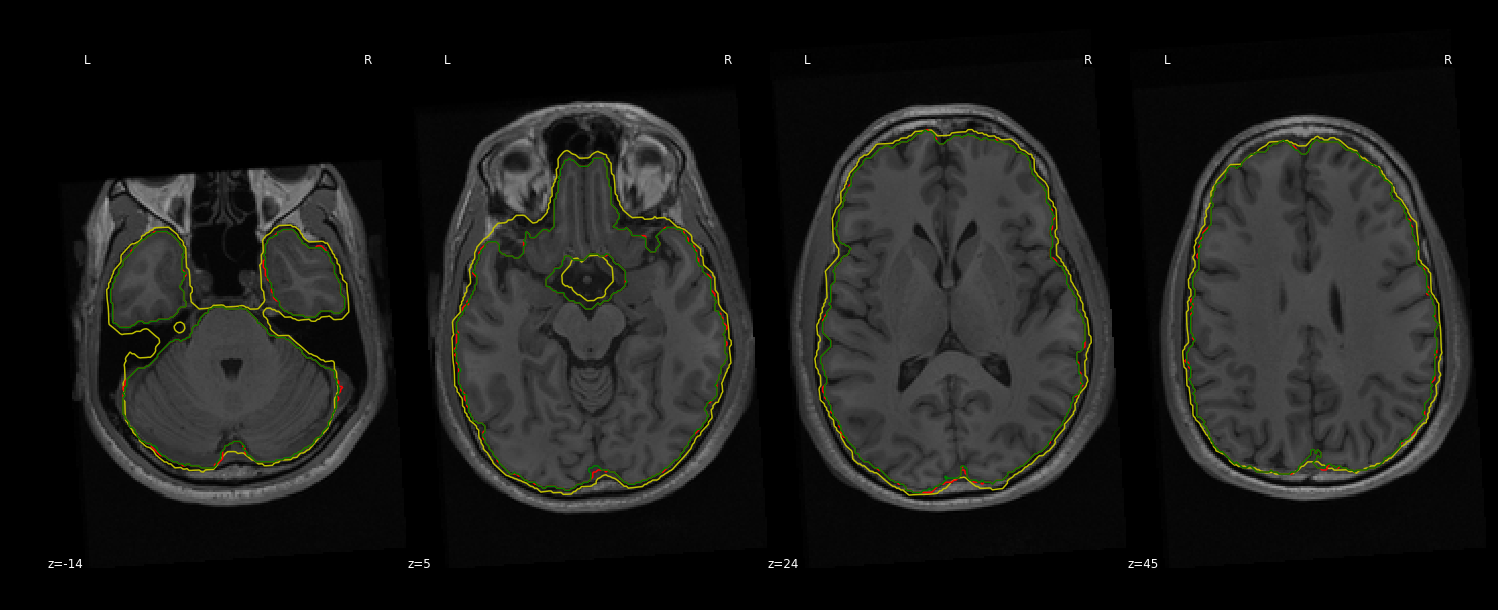

In [7]:
disp = plot_anat(anatnii, display_mode='z', cut_coords=[-14, 5, 24, 45])
disp.add_contours('ds017/antsmask.nii.gz', levels=[0.5], colors='y')
disp.add_contours('ds017/mask_wgmvox.nii.gz', levels=[0.5], colors='r')
disp.add_contours('ds017/mask_wogmvox.nii.gz', levels=[0.5], colors='g')
plt.gcf().set_size_inches(20, 8)